# Fingerprint match

Programul demonstreaza

In [1]:
!pip install fingerprint_enhancer

In [3]:
!pip install fingerprint_feature_extractor

  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_feature_extractor: filename=fingerprint_feature_extractor-0.0.10-py3-none-any.whl size=4829 sha256=1d9290015ecf0a33b50ab31fb716b43844c75b65fc5714715fe609c93265ed9d
  Stored in directory: /root/.cache/pip/wheels/30/85/fd/31e1eefbb140c9a611a41c2819bd2186e1384c108eff4d10e1
Successfully built fingerprint_feature_extractor


In [4]:
!pip install pycpd

In [26]:
!pip uninstall opencv-contrib-python opencv-python-headless -y

Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
Found existing installation: opencv-python-headless 4.11.0.86
Uninstalling opencv-python-headless-4.11.0.86:
  Successfully uninstalled opencv-python-headless-4.11.0.86


In [27]:
!pip install opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.0 MB/s eta 0:00:00


In [2]:
import cv2
import os
from fingerprint_enhancer import enhance_fingerprint
import fingerprint_feature_extractor
import numpy as np
from scipy.spatial import cKDTree
import math
from pycpd import RigidRegistration
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.spatial.distance import cdist
from google.colab import files
from google.colab.patches import cv2_imshow
import ipywidgets as widgets


# Functii

## Pair points

Funcția pair_points are rolul de a găsi și returna perechi de puncte din două seturi diferite, A și B, pe baza unei distanțe maxime permise între ele. Aceasta primește ca argumente două colecții de puncte bidimensionale (fie sub formă de liste, fie ca tablouri numpy) și o valoare numerică ce reprezintă pragul maxim de distanță admis pentru ca două puncte, unul din A și unul din B, să poată fi considerate potrivite.

În interiorul funcției, se transformă ambele seturi de puncte în tablouri numpy, dacă nu sunt deja. Apoi, se calculează distanțele dintre toate combinațiile posibile de puncte din cele două seturi, rezultând o matrice a distanțelor. Funcția identifică acele perechi de puncte pentru care distanța este mai mică sau egală cu pragul specificat. În final, întoarce două liste: una cu punctele din A care au fost asociate și cealaltă cu punctele din B corespunzătoare acestora.

Această funcție este utilă, de exemplu, în aplicații care implică potrivirea coordonatelor între două seturi de date spațiale, identificarea punctelor apropiate în plan sau alinierea datelor provenite din surse diferite.

In [3]:
def pair_points(A, B, threshold):
    """
    Pairs points from A and B based on a distance threshold.

    Parameters:
    - A (np.ndarray): 2D array or list of points (x, y) in the first set.
    - B (np.ndarray): 2D array or list of points (x, y) in the second set.
    - threshold (float): The maximum distance allowed for a pair to be considered.

    Returns:
    - paired_A (list): List of points from A that are paired with points from B.
    - paired_B (list): List of points from B that are paired with points from A.
    """

    # Convert to numpy arrays if A and B are lists
    A = np.array(A)
    B = np.array(B)

    # Compute all pairwise distances between points in A and B
    distances = cdist(A, B)

    # Find the points that can be paired based on the threshold
    pairs = np.where(distances <= threshold)

    # Extract the paired points from A and B
    paired_A = A[pairs[0]]
    paired_B = B[pairs[1]]

    return paired_A, paired_B

## Find threshold

Funcția find_threshold are scopul de a determina o valoare de prag (threshold) pe baza distribuției unui set de distanțe numerice. Aceasta analizează forma distribuției pentru a identifica o limită naturală între două regiuni semnificative din punct de vedere statistic.

Procesul începe prin construirea unui histogramă a valorilor din listă, folosind un număr optim de intervale determinat de o metodă specifică (în acest caz, metoda Freedman–Diaconis). Histogramă rezultată oferă o estimare a densității de distribuție a distanțelor.

După generarea histogramei, funcția caută "vârfuri" (valori locale maxime) în distribuție. Dacă este găsit cel puțin un vârf, funcția continuă cu identificarea primului dintre acestea, presupunând că acesta marchează o zonă de concentrație ridicată a valorilor (o modă locală). Apoi, se caută spre dreapta (adică spre valori mai mari) primul punct din histogramă unde densitatea scade sub jumătatea înălțimii acelui vârf – acest punct este interpretat ca o limită naturală între regiunea densă și restul distribuției.

Funcția returnează valoarea de pe axa X corespunzătoare acestui punct, considerată a fi pragul dorit. Dacă nu sunt identificate vârfuri, funcția returnează None și afișează un mesaj de avertizare. Acest tip de logică este util, de exemplu, în segmentarea automată a datelor, filtrarea valorilor sau extragerea caracteristicilor semnificative dintr-un set de distanțe.

In [4]:
def find_threshold(distances):
    # Step 1: Generate the histogram
    bins = optimal_bins(distances, method="fd")
    hist, bin_edges = np.histogram(distances, bins, density=True)


    # Step 3: Find the peaks in the cumulative distribution
    peaks, _ = find_peaks(hist)

    if len(peaks) > 0:
        # Step 4: Get the first peak
        first_peak_index = peaks[0]
        peak_value = hist[first_peak_index]

        # Step 5: Find the point where the peak reaches half height, farther from the origin
        half_max = peak_value / 2

        # Search to the right of the first peak for the point where the cumulative histogram drops below half_max
        right_idx = np.where(hist[first_peak_index:] <= half_max)[0][0] + first_peak_index

        # Step 6: Return the x-value corresponding to the point where the peak reaches half height
        threshold_x = bin_edges[right_idx]


        return threshold_x
    else:
        print("No peaks found in the cumulative histogram.")
        return None

## Align label points

Funcția align_labeled_point_sets are rolul de a alinia un set de puncte etichetate, denumit B, la un alt set de puncte etichetate, denumit A. Fiecare set este împărțit în două subgrupuri, marcate cu etichetele T și F (acestea pot reprezenta, de exemplu, două categorii sau clase diferite de puncte).

Inițial, funcția combină subgrupurile T și F din ambele seturi într-un singur tablou pentru fiecare set, păstrând ordinea punctelor astfel încât să fie posibilă reîmpărțirea ulterioară. Alinierea se face folosind o metodă de potrivire rigidă, care presupune transformări precum translații și rotații, dar fără deformări (nu modifică forma internă a setului de puncte).

După aplicarea transformării care aliniază setul B la setul A, rezultatul este împărțit înapoi în subgrupuri T și F, conform dimensiunii inițiale a fiecărei etichete. Funcția returnează aceste două subgrupuri transformate, corespunzătoare versiunii aliniate a setului B.

Această funcție este utilă în domenii precum procesarea imaginilor, recunoașterea de forme sau în alinierea datelor spațiale provenite din surse diferite, atunci când este importantă conservarea structurii etichetelor în timpul alinierii.

In [5]:
def align_labeled_point_sets(A_T, A_F, B_T, B_F):
    """
    Aligns point set B (with T and F labeled subgroups) to point set A.

    Args:
        A_T, A_F: list of (x, y) tuples for A's T and F subgroups
        B_T, B_F: list of (x, y) tuples for B's T and F subgroups

    Returns:
        aligned_B_T, aligned_B_F: transformed versions of B_T and B_F
    """
    # Combine A and B into full arrays
    A_combined = np.array(A_T + A_F, dtype=np.float64)
    B_combined = np.array(B_T + B_F, dtype=np.float64)

    # Keep track of label boundaries
    len_T = len(B_T)

    # Align B_combined to A_combined
    reg = RigidRegistration(X=A_combined, Y=B_combined)
    TY, _ = reg.register()

    # Split the aligned result
    aligned_B_T = [tuple(pt) for pt in TY[:len_T]]
    aligned_B_F = [tuple(pt) for pt in TY[len_T:]]

    return aligned_B_T, aligned_B_F

## Optimal bins

Funcția optimal_bins calculează un număr optim de intervale (bins) pentru construirea unei histograme pe baza unui set de date numerice. Scopul său este de a ajusta granularitatea histogramei în funcție de distribuția datelor și de dimensiunea eșantionului, astfel încât reprezentarea grafică să fie cât mai informativă și echilibrată.

Aceasta primește ca argument un vector de date și un parametru opțional care indică metoda utilizată pentru determinarea numărului de intervale. Dacă se alege metoda "sturges", numărul de bins este calculat folosind o formulă logaritmică în funcție de numărul total de valori. Metoda "rice" folosește o formulă bazată pe rădăcina cubică a numărului de elemente, fiind mai potrivită pentru seturi mari. Metoda "scott" calculează lățimea fiecărui bin pe baza deviației standard și apoi derivă numărul total de bins. Metoda implicită, "fd" (Freedman–Diaconis), utilizează distanța intercuartilică pentru a estima lățimea optimă a binurilor, fiind mai robustă la extreme și la distribuții asimetrice.

Funcția returnează numărul total de intervale corespunzător metodei alese. Dacă lățimea estimată pentru binuri este zero (de exemplu, în cazul în care toate valorile sunt identice), funcția revine cu o valoare implicită de 10 intervale. Această funcție este utilă în analiza exploratorie a datelor și în vizualizările statistice, unde alegerea greșită a numărului de bins poate distorsiona interpretarea distribuției.

In [6]:
def optimal_bins(data, method="fd"):
    n = len(data)
    data = np.asarray(data)
    range_ = np.max(data) - np.min(data)

    if method == "sturges":
        return int(np.ceil(np.log2(n) + 1))
    elif method == "rice":
        return int(np.ceil(2 * n ** (1/3)))
    elif method == "scott":
        bin_width = 3.5 * np.std(data) / (n ** (1/3))
    elif method == "fd":
        q75, q25 = np.percentile(data, [75 ,25])
        iqr = q75 - q25
        bin_width = 2 * iqr / (n ** (1/3))
    else:
        raise ValueError("Unknown method for bin selection.")

    return int(np.ceil(range_ / bin_width)) if bin_width > 0 else 10

## Nearest Neighbour distances

Functia primește două seturi de puncte, A și B_aligned, și calculează calitatea aliniamentului dintre ele. Primul pas al funcției este să convertească cele două seturi de puncte într-un format de tip numpy.ndarray. Apoi, se construiește un arbore KD (k-dimensional tree) folosind setul A pentru a facilita căutările rapide ale celor mai apropiate puncte din A pentru fiecare punct din B_aligned.

După aceea, se calculează distanțele între punctele din B_aligned și cele mai apropiate puncte din A utilizând metoda query a arborelui KD. Aceste distanțe sunt apoi procesate printr-o funcție denumită optimal_bins, care determină numărul optim de bin-uri pentru un histogramă bazată pe distanțele calculate. Funcția optimal_bins folosește un parametru opțional, bin_method, care specifică metoda folosită pentru determinarea bin-urilor. Dacă nu este specificată o metodă, aceasta va folosi metoda implicită "fd" (Freedman-Diaconis). Rezultatul acestei funcții este returnat, oferind o estimare a calității aliniamentului între cele două seturi de puncte.

In [7]:
def nearest_neighbor_distances(A, B_aligned, bin_method="fd"):
    A = np.array(A)
    B_aligned = np.array(B_aligned)

    tree = cKDTree(A)
    distances, _ = tree.query(B_aligned)

    bins = optimal_bins(distances, method=bin_method)

    stats = {
        "mean": np.mean(distances),
        "median": np.median(distances),
        "std": np.std(distances),
        "min": np.min(distances),
        "max": np.max(distances),
        "num_points": len(distances),
        "within_1_unit": np.sum(distances < 1.0),
        "within_5_units": np.sum(distances < 5.0)
    }

    return distances, stats

## Deseneaza caracteristicile amprentei

In [8]:
def draw_fingerprint_features(image, FeaturesTerminations, FeaturesBifurcations):

    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Draw termination minutiae (red circles)
    for curr_minutiae in FeaturesTerminations:
        row, col = int(curr_minutiae.locY), int(curr_minutiae.locX)  # OpenCV uses (x, y) as (col, row)
        cv2.circle(color_image, (row, col), 6, (0, 0, 255), 2)  # Red circle

    # Draw bifurcation minutiae (blue circles)
    for curr_minutiae in FeaturesBifurcations:
        row, col = int(curr_minutiae.locY), int(curr_minutiae.locX)
        cv2.circle(color_image, (row, col), 6, (255, 0, 0), 2)  # Blue circle

    return color_image

## Deseneaza caracteristicile amprentei din liste

In [9]:
def draw_fingerprint_features_from_lists(image, terminations_coordinates, bifurcation_coordinates):

    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Draw termination minutiae (red circles)
    for (col, row) in terminations_coordinates:
        cv2.circle(color_image, (int(row), int(col)), 6, (0, 0, 255), 2)  # Red circle

    # Draw bifurcation minutiae (blue circles)
    for (col, row) in bifurcation_coordinates:
        cv2.circle(color_image, (int(row), int(col)), 6, (255, 0, 0), 2)  # Blue circle

    return color_image

## Deseneaza liniile de orientare

In [10]:
def draw_termination_lines(image, FeaturesTerminations, line_length=10, color=(0, 0, 255), thickness=1):
    """
    Draws small lines on the image at the (x, y) locations with the angle from the list in the third element.

    Args:
        image (np.ndarray): The OpenCV image on which to draw.
        terminations (list): List of tuples, where each tuple contains (x, y, [angle]).
        line_length (int): Length of the line to draw.
        color (tuple): Color of the line in BGR format.
        thickness (int): Thickness of the line.

    Returns:
        np.ndarray: The image with lines drawn.
    """

    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for curr_minutiae in FeaturesTerminations:
        row, col = int(curr_minutiae.locY), int(curr_minutiae.locX)  # OpenCV uses (x, y) as (col, ro
        orient = curr_minutiae.Orientation

        if len(orient) == 1:  # Ensure the third element is a list with one angle
            angle = orient[0]
            # Convert angle to radians
            angle_rad = math.radians(angle)

            # Calculate the end point of the line
            row_end = int(row + line_length * math.cos(angle_rad))
            col_end = int(col - line_length * math.sin(angle_rad))  # Subtract because OpenCV's origin is top-left

            # Draw the line
            cv2.line(color_image, (int(row), int(col)), (row_end, col_end), color, thickness)

    return color_image

## Creaza o imagine din doua surse

In [11]:
def create_side_by_side_image(img1, img2, label1, label2):
    """
    Creates an OpenCV image showing two images side by side with labels centered above them.

    Args:
        img1 (np.ndarray): First grayscale image.
        img2 (np.ndarray): Second grayscale image.
        label1 (str): Label for the first image (e.g., file name without path).
        label2 (str): Label for the second image (e.g., file name without path).

    Returns:
        np.ndarray: Combined image with labels and spacing.
    """
    # Ensure both images are grayscale
    if len(img1.shape) == 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    if len(img2.shape) == 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Get dimensions of the images
    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape

    # Determine the height of the combined image (max height of both images + space for labels)
    label_space = 50  # Space for labels above the images
    combined_height = max(h1, h2) + label_space

    # Create a blank canvas for the combined image
    combined_width = w1 + w2 + 50  # Add 50 pixels of space between the images
    combined_image = np.ones((combined_height, combined_width, 3), dtype=np.uint8) * 255  # White background

    # Place the first image on the canvas, aligned at the top
    combined_image[label_space:label_space + h1, :w1] = img1

    # Place the second image on the canvas, aligned at the top
    combined_image[label_space:label_space + h2, w1 + 50:w1 + 50 + w2] = img2

    # Add labels above the images
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2

    # Calculate text size and position for the first label
    text_size1 = cv2.getTextSize(label1, font, font_scale, font_thickness)[0]
    text_x1 = (w1 - text_size1[0]) // 2
    text_y1 = (label_space - text_size1[1]) // 2 + text_size1[1]
    cv2.putText(combined_image, label1, (text_x1, text_y1), font, font_scale, (0, 0, 0), font_thickness)

    # Calculate text size and position for the second label
    text_size2 = cv2.getTextSize(label2, font, font_scale, font_thickness)[0]
    text_x2 = w1 + 50 + (w2 - text_size2[0]) // 2
    text_y2 = (label_space - text_size2[1]) // 2 + text_size2[1]
    cv2.putText(combined_image, label2, (text_x2, text_y2), font, font_scale, (0, 0, 0), font_thickness)

    return combined_image

## Calculeaza eroarea medie patratica

Funcția mse calculează eroarea pătratică medie (Mean Squared Error) dintre două seturi de puncte, presupunând că aceste seturi conțin puncte bidimensionale (x, y) și că punctele din cele două seturi sunt deja pereche, adică se află în corespondență unul la unul.

Pentru fiecare pereche de puncte, se calculează diferența coordonatelor, rezultând un vector de eroare. Acest vector este apoi pătrat element cu element, iar valorile pătratice sunt adunate pe fiecare pereche de puncte. Suma obținută pentru fiecare pereche este media eroarii pătratice pentru acea observație. În final, se calculează media acestor valori, oferind astfel o măsură globală a diferenței dintre cele două seturi.

Această funcție este des utilizată în învățarea automată, procesarea imaginilor și analiza datelor, pentru a evalua cât de apropiate sunt două seturi de puncte, modele sau estimări numerice față de valorile reale. Cu cât valoarea returnată este mai mică, cu atât seturile sunt mai similare.

In [12]:
def mse(set_a, set_b):
    # Assuming set_a and set_b are lists of matched points (x, y)
    differences = np.array(set_a) - np.array(set_b)
    squared_diff = np.sum(differences ** 2, axis=1)
    mse_value = np.mean(squared_diff)
    return mse_value

## eroarea procentuală absolută medie simetrică

Funcția smape calculează eroarea procentuală absolută medie simetrică (Symmetric Mean Absolute Percentage Error) dintre două seturi de puncte. Aceste seturi sunt presupuse a fi deja aliniate, adică fiecare element din set_a corespunde pozițional cu un element din set_b.

În primul pas, ambele seturi sunt transformate în tablouri NumPy pentru a permite operații vectorizate. Se calculează apoi diferența absolută dintre punctele corespunzătoare, ceea ce oferă măsura erorii brute dintre valorile reale și cele estimate. Denumitorul este format din media valorilor absolute ale fiecărei perechi, astfel încât eroarea rezultată să fie normalizată în raport cu dimensiunea valorilor implicate. Această formulă are avantajul de a fi simetrică — penalizează în mod egal deviațiile pozitive și negative.

Rezultatul este media acestor erori normalizate, înmulțită cu 100 pentru a fi exprimată în procente. smape este adesea utilizată în domenii precum prognoza seriilor temporale sau evaluarea performanței modelelor de regresie, unde este importantă o măsură relativă a erorii care să nu fie influențată excesiv de valorile extreme sau de variații mari în magnitudinea datelor.

In [13]:
def smape(set_a, set_b):
    set_a, set_b = np.array(set_a), np.array(set_b)
    diff = np.abs(set_a - set_b)
    denominator = (np.abs(set_a) + np.abs(set_b)) / 2.0
    return np.mean(2 * diff / denominator) * 100

# Programul principal

In [14]:
first_image_name = ''
second_image_name = ''

## Incarcarea primei imagini

In [15]:
uploaded1 = files.upload()

for fn in uploaded1.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded1[fn])))

for fn in uploaded1.keys():
    # Extract the file name without path
    first_image_name = os.path.basename(fn)

first_image = cv2.imdecode(np.frombuffer(uploaded1[fn], np.uint8), cv2.IMREAD_UNCHANGED)


Saving 103_1.png to 103_1 (1).png
User uploaded file "103_1 (1).png" with length 111742 bytes


## Incarcarea celei de-a doua imagini

In [16]:
uploaded2 = files.upload()

for fn in uploaded2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded2[fn])))

for fn in uploaded2.keys():
    # Extract the file name without path
    second_image_name = os.path.basename(fn)

second_image = cv2.imdecode(np.frombuffer(uploaded2[fn], np.uint8), cv2.IMREAD_UNCHANGED)

Saving 103_1_r_35_a.png to 103_1_r_35_a.png
User uploaded file "103_1_r_35_a.png" with length 106712 bytes


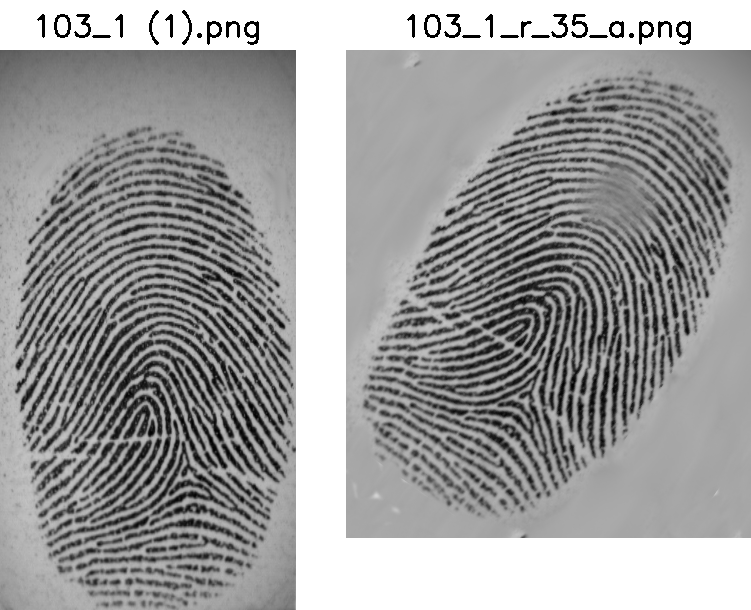

In [17]:
original_images = create_side_by_side_image(first_image, second_image, first_image_name, second_image_name)
cv2_imshow(original_images)

## Preprocesarea imaginilor

In [18]:
fa_enhanced_image = enhance_fingerprint(first_image)
fa_enhanced_image = (fa_enhanced_image * 255).astype(np.uint8)



In [19]:
fb_enhanced_image = enhance_fingerprint(second_image)
fb_enhanced_image = (fb_enhanced_image * 255).astype(np.uint8)

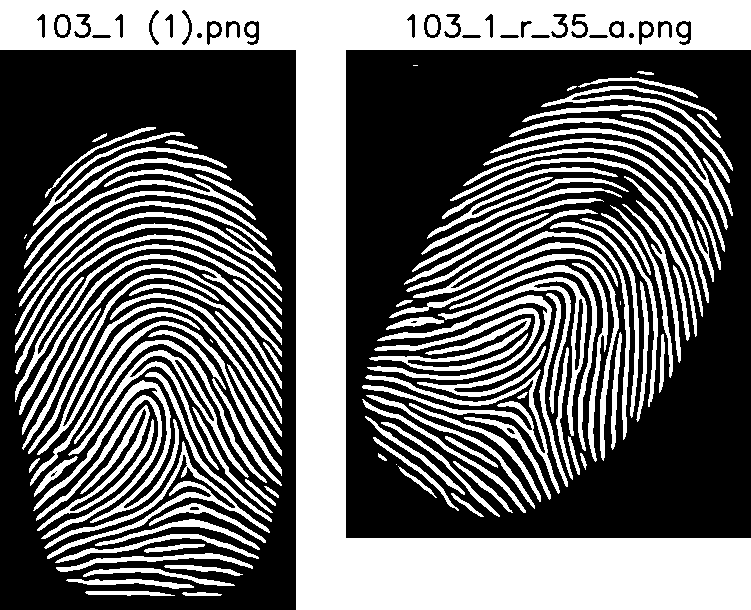

In [20]:
clean_images = create_side_by_side_image(fa_enhanced_image, fb_enhanced_image, first_image_name, second_image_name)
cv2_imshow(clean_images)

## Afisarea imaginilor scheletice

In [21]:
fa_skeleton_image = cv2.ximgproc.thinning(fa_enhanced_image)

In [22]:
fb_skeleton_image = cv2.ximgproc.thinning(fb_enhanced_image)

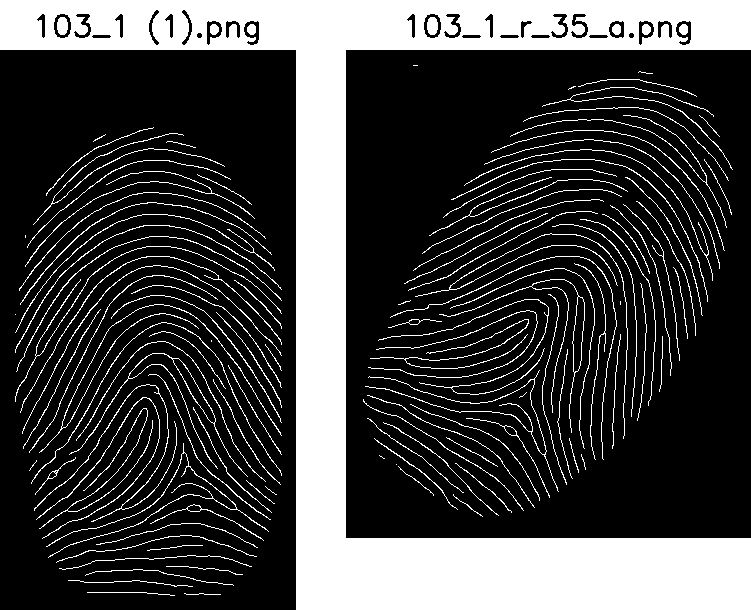

In [23]:
skeleton_images = create_side_by_side_image(fa_skeleton_image, fb_skeleton_image, first_image_name, second_image_name)
cv2_imshow(skeleton_images)

## Extragerea punctelor caracteristice

In [24]:
FeaturesTerminations_a, FeaturesBifurcations_a = fingerprint_feature_extractor.extract_minutiae_features(fa_enhanced_image, spuriousMinutiaeThresh=20, invertImage=False, showResult=False, saveResult=False)


/usr/local/lib/python3.11/dist-packages/fingerprint_feature_extractor/__init__.py:78: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  self._mask = erosion(self._mask, square(5))  # Structuing element for mask erosion = square(5)


In [25]:
terminations_a_coords = [(f.locX, f.locY) for f in FeaturesTerminations_a]
bifurcations_a_coords = [(f.locX, f.locY) for f in FeaturesBifurcations_a]

In [26]:
FeaturesTerminations_b, FeaturesBifurcations_b = fingerprint_feature_extractor.extract_minutiae_features(fb_enhanced_image, spuriousMinutiaeThresh=20, invertImage=False, showResult=False, saveResult=False)


In [27]:
terminations_b_coords = [(f.locX, f.locY) for f in FeaturesTerminations_b]
bifurcations_b_coords = [(f.locX, f.locY) for f in FeaturesBifurcations_b]

## Afisarea caracteristicilor identificate pe cele doua imagini

In [28]:
fa_skeleton_image = cv2.bitwise_not(fa_skeleton_image)
fa_features_image = draw_fingerprint_features(fa_skeleton_image, FeaturesTerminations_a, FeaturesBifurcations_a)

In [29]:
fb_skeleton_image = cv2.bitwise_not(fb_skeleton_image)
fb_features_image = draw_fingerprint_features(fb_skeleton_image, FeaturesTerminations_b, FeaturesBifurcations_b)


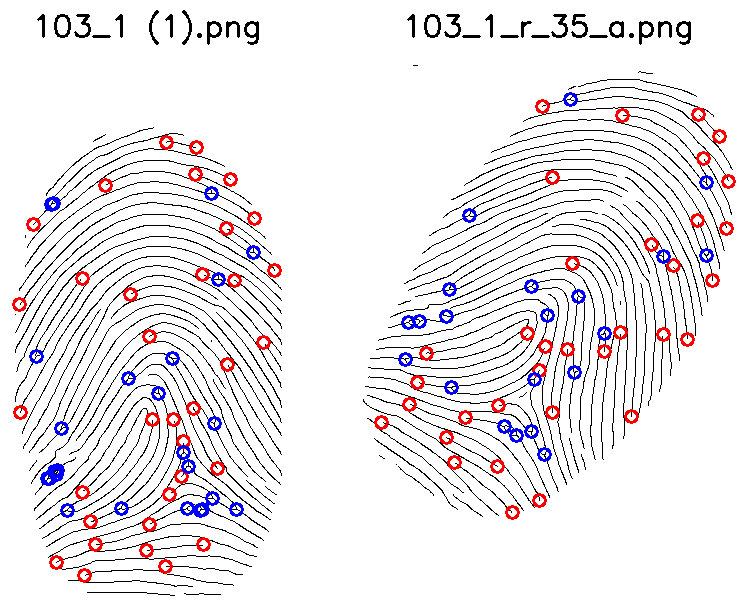

In [30]:
feature_images = create_side_by_side_image(fa_features_image, fb_features_image, first_image_name, second_image_name)
cv2_imshow(feature_images)

In [31]:
fa_skeleton_image_with_lines = draw_termination_lines(fa_skeleton_image, FeaturesTerminations_a, line_length=20, color=(255, 0, 0), thickness=2)


In [32]:
fb_skeleton_image_with_lines = draw_termination_lines(fb_skeleton_image, FeaturesTerminations_b, line_length=20, color=(255, 0, 0), thickness=2)


## Afisarea orientarilor

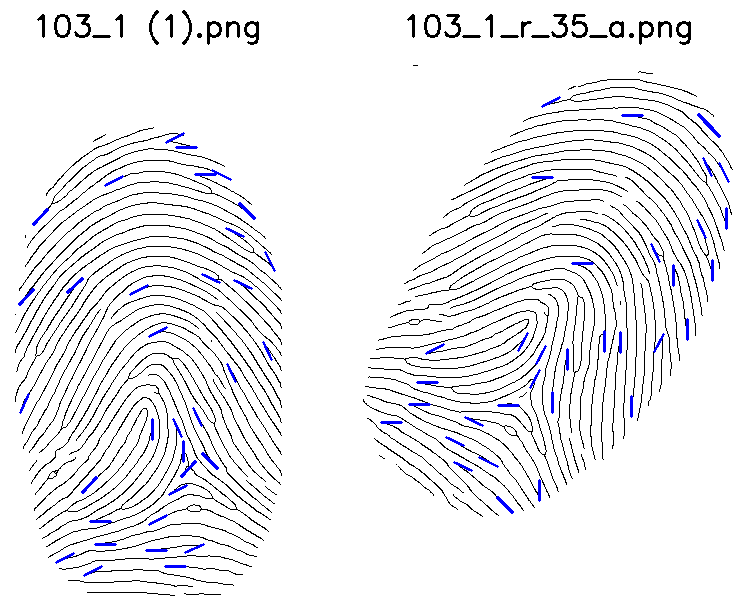

In [33]:
feature_images_lines = create_side_by_side_image(fa_skeleton_image_with_lines, fb_skeleton_image_with_lines, first_image_name, second_image_name)
cv2_imshow(feature_images_lines)

## Alinierea punctelor din setul de test cu setul initial

In [34]:
aligned_terminations, aligned_bifurcations = align_labeled_point_sets(terminations_a_coords, bifurcations_a_coords, terminations_b_coords, bifurcations_b_coords)


In [35]:
int_aligned_terminations = [(int(x), int(y)) for (x, y) in aligned_terminations]
int_aligned_bifurcations = [(int(x), int(y)) for (x, y) in aligned_bifurcations]

original_points = np.vstack([terminations_a_coords, bifurcations_a_coords])
aligned_points = np.vstack([aligned_terminations, aligned_bifurcations])

In [36]:
post_alignment_image = draw_fingerprint_features_from_lists(fa_skeleton_image, int_aligned_terminations, int_aligned_bifurcations)


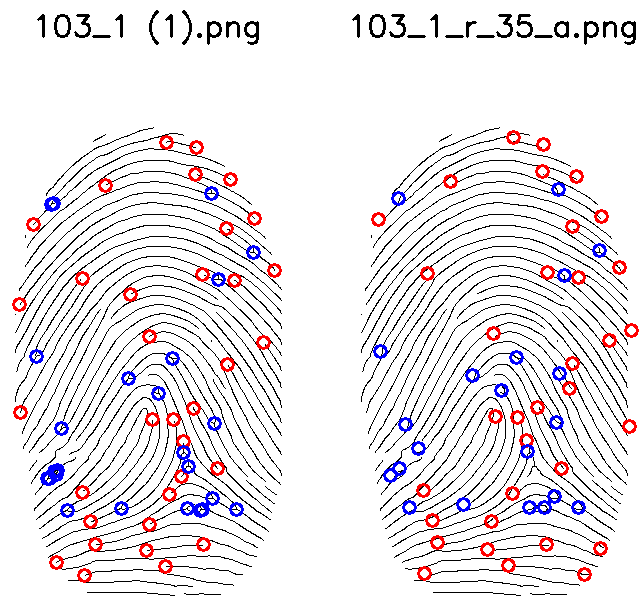

In [37]:
post_alignment_images = create_side_by_side_image(fa_features_image, post_alignment_image, first_image_name, second_image_name)
cv2_imshow(post_alignment_images)

## Distantele

Obtinem distantele dintre puncte si cei mai apropiati vecini.

In [38]:
distances, stats = nearest_neighbor_distances(original_points, aligned_points, bin_method="fd")

In [40]:
threshold = find_threshold(distances)

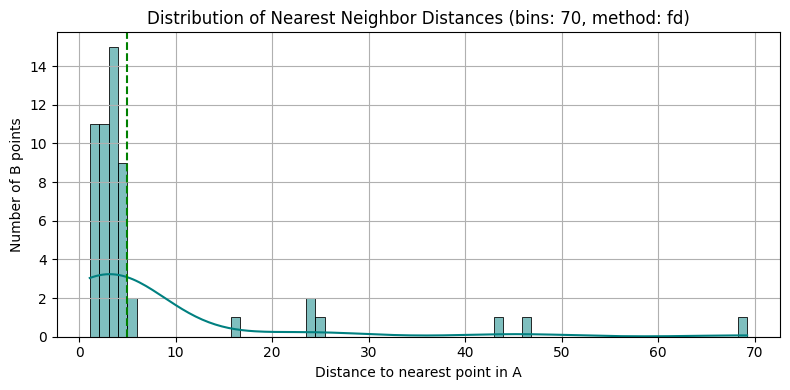

In [41]:
bins = optimal_bins(distances, method="fd")
plt.figure(figsize=(8, 4))
sns.histplot(distances, bins=bins, kde=True, color='teal')
plt.axvline(x=threshold, color='g', linestyle='--', label="Threshold at Half Height")
plt.title(f"Distribution of Nearest Neighbor Distances (bins: {bins}, method: fd)")
plt.xlabel("Distance to nearest point in A")
plt.ylabel("Number of B points")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

## Threshold

Pe baza analizei statistice a distantelor putem observa daca majoritatea distantelor se acumuleaza in zona inferioara a histogramei. Aceasta inseamna ca majoritatea distantelor sunt mici si ca cele doua seturi de puncte sunt apropiate. Daca aceasta este situatia, putem sa extragem doar acele puncte care sunt apropiate unul de celalalt, evitand punctele lipsa sau determinate de zgomot.


In [ ]:
threshold = find_threshold(distances)
print(f"Threshold {threshold}")
if threshold is not None:
    paired_A, paired_B = pair_points(original_points, aligned_points, threshold)
    print(f" Prima matrice: {len(paired_A)} A doua matrice: {len(paired_B)} ")
else:
    print("No valid threshold found.")

Threshold 35.004274512714574
 Prima matrice: 92 A doua matrice: 92 


## Metrici ale distantei dintre cele doua seturi de puncte

In [ ]:
if threshold is not None:
  mse = mse(paired_A, paired_B)
  smape = smape(paired_A, paired_B)

TypeError: 'numpy.float64' object is not callable

In [ ]:
print(f"MSE: {mse}")
print(f"SMAPE: {smape}")

MSE: 6.345480217886117
SMAPE: 1.9074117955467662
